In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans

In [2]:
# Load data
df = pd.read_csv('Tickets_data.csv')

In [3]:
df.head(2)

,Summary,Issue key,Issue id,Issue Type,Status,Project key,Project name,Project type,Project lead,Project description,...,Comment.17,Comment.18,Comment.19,Comment.20,Comment.21,Comment.22,Comment.23,Comment.24,Comment.25,Comment.26
0,NPE during test execution on IntelliJ 2016.3 W...,CLOV-1985,660317,Bug,Closed,CLOV,Clover,software,mparfianowicz,This is a public issue tracker for Atlassian C...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Instrumentation error for generic array constr...,CLOV-1984,659733,Bug,Closed,CLOV,Clover,software,mparfianowicz,This is a public issue tracker for Atlassian C...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Columns: 269 entries, Summary to Comment.26
dtypes: bool(1), float64(125), int64(10), object(133)
memory usage: 1.1+ MB


In [5]:
df['Issue Type'].unique()

array(['Bug'], dtype=object)

In [6]:
df['Resolution'].unique()

array(["Won't Fix", 'Tracked Elsewhere', 'Handled by Support', 'Fixed',
       'Invalid', 'Obsolete', 'Cannot Reproduce', 'Duplicate',
       'Not a bug', 'Answered', 'Timed out', 'Resolved Locally',
       'Unsolved Mysteries'], dtype=object)

In [7]:
df['Component/s'].unique()

array(['CIJ Plugin', 'Instrumentation', nan, 'CEP Plugin', 'Integrations',
       'Groovy', 'Build system', 'Maven plugin', 'Ant Tasks',
       'Grails Plugin', 'Documentation', 'Database', 'Reporting',
       'Test Optimization'], dtype=object)

In [8]:
df = df.dropna(subset=['Summary', 'Resolution', 'Component/s'])

In [9]:
df.head(2)

,Summary,Issue key,Issue id,Issue Type,Status,Project key,Project name,Project type,Project lead,Project description,...,Comment.17,Comment.18,Comment.19,Comment.20,Comment.21,Comment.22,Comment.23,Comment.24,Comment.25,Comment.26
0,NPE during test execution on IntelliJ 2016.3 W...,CLOV-1985,660317,Bug,Closed,CLOV,Clover,software,mparfianowicz,This is a public issue tracker for Atlassian C...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Instrumentation error for generic array constr...,CLOV-1984,659733,Bug,Closed,CLOV,Clover,software,mparfianowicz,This is a public issue tracker for Atlassian C...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* <b> Clean the Text Data </b>

In [10]:
# Clean the 'Summary' column
def clean_text(text):
    text = re.sub(r'\W+', ' ', text)  
    text = text.lower().strip() 
    return text

df['cleaned_summary'] = df['Summary'].apply(clean_text)

# Display cleaned text
print("\nCleaned Summary Column:\n", df['cleaned_summary'].head())



Cleaned Summary Column:
 0    npe during test execution on intellij 2016 3 w...
1    instrumentation error for generic array constr...
3    __clr4_1_2_test_name_sniffer is ambiguous comp...
5      enabling clover working set throws an exception
7    code metrics should take into account method c...
Name: cleaned_summary, dtype: object


*<b> Assign Ticket Levels Using Clustering</b>

In [11]:
# Convert text into numerical features using TF-IDF

vectorizer = TfidfVectorizer(max_features=500)
text_features = vectorizer.fit_transform(df['cleaned_summary']).toarray()

In [24]:
pip install --upgrade threadpoolctl

  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
Note: you may need to restart the kernel to use updated packages.


In [19]:
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  
os.environ['OMP_NUM_THREADS'] = '2'    


In [27]:
# Apply KMeans Clustering
num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['ticket_level'] = kmeans.fit_predict(text_features)

C:\Users\Harry\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [28]:
cluster_to_level = {0: 'L1', 1: 'L2', 2: 'L3'}  
df['ticket_level'] = df['ticket_level'].map(cluster_to_level)

print("\nAssigned Ticket Levels:\n", df[['Summary', 'ticket_level']].head())


Assigned Ticket Levels:
                                              Summary ticket_level
0  NPE during test execution on IntelliJ 2016.3 W...           L1
1  Instrumentation error for generic array constr...           L1
3  __CLR4_1_2_TEST_NAME_SNIFFER is ambiguous comp...           L1
5    Enabling Clover working set throws an exception           L3
7  Code metrics should take into account method c...           L1


In [32]:
print("\nAssigned Ticket Levels:\n", df[['Summary', 'ticket_level']].head(20))


Assigned Ticket Levels:
                                               Summary ticket_level
0   NPE during test execution on IntelliJ 2016.3 W...           L1
1   Instrumentation error for generic array constr...           L1
3   __CLR4_1_2_TEST_NAME_SNIFFER is ambiguous comp...           L1
5     Enabling Clover working set throws an exception           L3
7   Code metrics should take into account method c...           L1
8   Exclusion Annotations setting works non-determ...           L1
10                        Fix Ant 1.9.7 double quotes           L1
11  Clover does not instrument all nodes in Groovy...           L1
12                 SonarQube - resource was not found           L1
13  Parser error on valid generic array constructo...           L1
14  Allow usage of explicit "this" as first method...           L1
17  "Client missing parameter: __CLR4_0_4_TEST_NAM...           L2
18  CloverCompilerAdapter should look for Javac.co...           L1
19       Compilation error while ins

In [33]:
df['ticket_level'].value_counts()

ticket_level
L1    307
L3     63
L2     47
Name: count, dtype: int64

* <b> Split Data for Model Training </b>

In [34]:
# Define features (TF-IDF matrix) and target (ticket_level)

X = text_features
y = df['ticket_level']  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"\nTraining Data Size: {X_train.shape}")
print(f"Test Data Size: {X_test.shape}")



Training Data Size: (333, 500)
Test Data Size: (84, 500)


* <b> Train a Classification Model </b>

In [ ]:
# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

In [36]:
y_pred = model.predict(X_test)

In [37]:
# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        64
           1       1.00      1.00      1.00         8
           2       1.00      0.50      0.67        12

    accuracy                           0.93        84
   macro avg       0.97      0.83      0.87        84
weighted avg       0.93      0.93      0.92        84

Model Accuracy: 92.86%


* <b> Save the Model for Deployment </b>

In [39]:
import joblib

# Save the trained model
joblib.dump(model, 'ticket_categorization_model.pkl')
print("Model saved as 'ticket_categorization_model.pkl'.")

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'.")

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')
print("Label encoder saved as 'label_encoder.pkl'.")

Model saved as 'ticket_categorization_model.pkl'.
TF-IDF vectorizer saved as 'tfidf_vectorizer.pkl'.
Label encoder saved as 'label_encoder.pkl'.


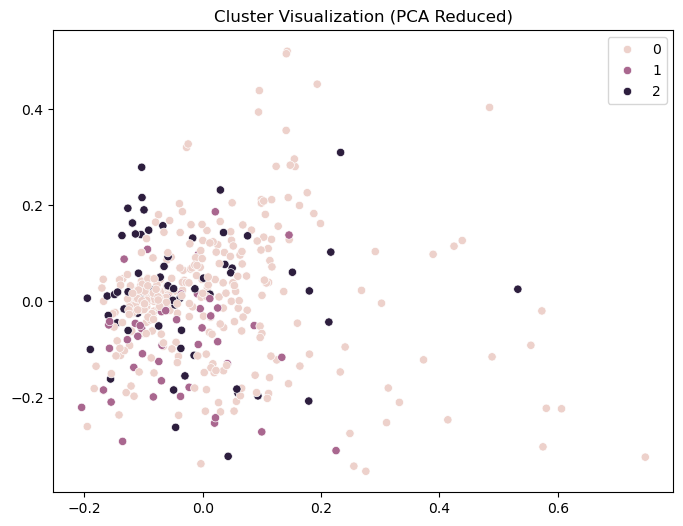

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization (if using more than 2 features)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(text_features)

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=kmeans.labels_)
plt.title("Cluster Visualization (PCA Reduced)")
plt.show()